# CNN model (with weeks)

This notebook trains a convolutional layer over the input probability distributions.

In [42]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils.data as udata
import utils.dists as udists
import utils.misc as u
import os
import losses
import pymmwr

from functools import partial
from jrun import jin
from keras.layers import (Activation, Convolution1D, Convolution2D, Dense,
                          Dropout, Embedding, Flatten, Merge, Input)
from keras.layers.merge import Concatenate, concatenate
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
import keras.backend as K

## Setup notebook parameters

In [44]:
EXP_NAME = jin("exp", "cnn-weeks/seasons-4-to-3")
COMPONENTS = jin("components", ["ReichLab-KCDE", "Delphi-EmpiricalFuture", "CU-EAKFC", "ReichLab-SARIMA2"])
WEEK_NUMBER = jin("week", 4)
TEST_SPLIT_THRESH = jin("splitweek", 201443)

## Load data

In [45]:
class Component:
    """
    Helper class for working with components
    """
    
    def __init__(self, name):
        self.name = name
        self.loader = udata.ComponentDataLoader("../data", name)

In [46]:
components = [Component(name) for name in COMPONENTS]
actual_dl = udata.ActualDataLoader("../data")

### Working on week ahead predictions

We need to take the common row entries (common "epiweek", "region") for each data item, i.e. actual data and component data.

In [47]:
REGION = None # Specify None for using all the data

y, Xs, yi = udata.get_week_ahead_training_data(
    WEEK_NUMBER, REGION,
    actual_dl, [cmp.loader for cmp in components]
)

for idx, cmp in enumerate(components):
    cmp.data = Xs[idx]

### Creating input matrices for model

In [48]:
weeks = u.encode_epiweeks_sin(np.array(yi[:, 0], dtype=np.int))
X = udists.get_2d_features(Xs)
y = udists.wili_to_dists(y)

### Split based on year
We take items before a certain epiweek as train and rest as test

In [49]:
train_indices = yi[:, 0] < TEST_SPLIT_THRESH

## Model

In [50]:
def conv1D_distribution(n_components,
                        n_bins,
                        week_embedding_size):
    """
    One dimensional conv model over input distribution to give an output
    distribution

    Merges two branches
    - predictions : (batch_size, n_bins, n_models)
    - weeks : (batch_size, week_embedding_size)

    Parameters
    ----------
    n_components : int
        Number of component distributions
    n_bins : int
        Number of bins in the prediction distribution
    week_embedding_size : int
        Embedding vector size for week
    """

    dist_input = Input(shape=(n_bins, n_components))
    week_input = Input(shape=(week_embedding_size,))

    # Dist branch
    dist_x = Convolution1D(32, 5, padding="same")(dist_input)
    dist_x = Convolution1D(10, 3, padding="same")(dist_x)
    dist_x = Flatten()(dist_x)
    dist_x = Dense(10, activation="tanh")(dist_x)

    week_x = Dense(10, activation="tanh")(week_input)
    week_x = Dense(10)(week_x)

    merged = concatenate([dist_x, week_x])
    merged = Dense(20, activation="relu")(merged)
    merged = Dense(n_bins, activation="softmax")(merged)
    
    model = Model(inputs=[dist_input, week_input], outputs=merged)

    return model

### Training

In [51]:
# model generator
def gen_model():
    return conv1D_distribution(X.shape[-1], X.shape[1], 2)

def train_model(
    model, train_data, val_data,
    batch_size=64, epochs=100,
    verbose=0
):
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

    if val_data is not None:
        callbacks = [EarlyStopping(monitor="val_loss", patience=4, mode="auto")]
    else:
        callbacks = []

    history = model.fit(train_data[0],
                        train_data[1],
                        batch_size=batch_size, epochs=epochs,
                        verbose=verbose,
                        callbacks=callbacks,
                        validation_data=val_data)
    return history

100%|██████████| 4/4 [03:05<00:00, 46.12s/it]


,epochs,train_loss,val_loss
it-1,40.0,2.926155,3.419105
it-2,47.0,2.979183,3.169914
it-3,32.0,2.973646,3.744743
it-4,47.0,2.962375,3.200866
mean,41.5,2.960340,3.383657


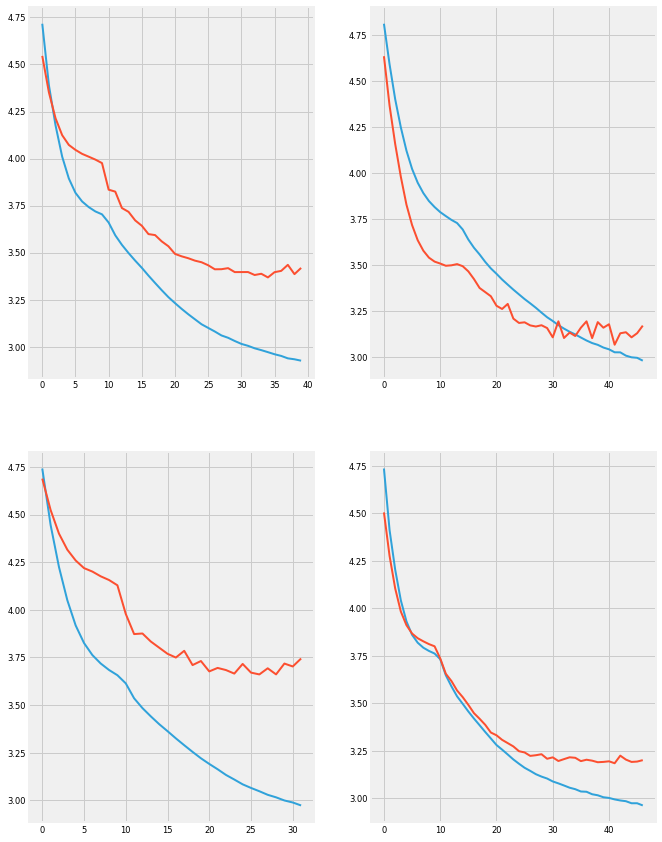

In [52]:
cv_metadata = u.cv_train_loso(
    gen_model, train_model,
    [X[train_indices], weeks[train_indices]], y[train_indices], yi[train_indices]
)
u.cv_plot(cv_metadata)
cv_report = u.cv_report(cv_metadata)
cv_report

### Final model training

Epoch 1/41
1232/1232 [==============================] - 1s - loss: 4.7477     
Epoch 2/41
1232/1232 [==============================] - 1s - loss: 4.3817     
Epoch 3/41
1232/1232 [==============================] - 1s - loss: 4.1346     
Epoch 4/41
1232/1232 [==============================] - 1s - loss: 3.9667     
Epoch 5/41
1232/1232 [==============================] - 1s - loss: 3.8639     
Epoch 6/41
1232/1232 [==============================] - 1s - loss: 3.8087     
Epoch 7/41
1232/1232 [==============================] - 1s - loss: 3.7798     
Epoch 8/41
1232/1232 [==============================] - 1s - loss: 3.7616     
Epoch 9/41
1232/1232 [==============================] - 1s - loss: 3.7463     
Epoch 10/41
1232/1232 [==============================] - 1s - loss: 3.6627     
Epoch 11/41
1232/1232 [==============================] - 1s - loss: 3.6035     
Epoch 12/41
1232/1232 [==============================] - 1s - loss: 3.5590     
Epoch 13/41
1232/1232 [==========================

3.0034633797484558

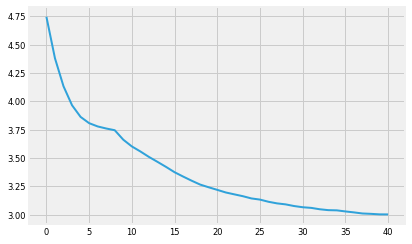

In [53]:
model = gen_model()
final_epochs = int(cv_report["epochs"][-1])
final_history = train_model(
    model,
    ([X[train_indices], weeks[train_indices]], y[train_indices]),
    None, epochs=final_epochs, verbose=1)
final_loss = final_history.history["loss"][-1]
plt.plot(final_history.history["loss"])
final_loss

### Evaluation

In [54]:
regions = ["nat", *[f"hhs{i}" for i in range(1, 11)], None]

mdls = [*[cmp.name for cmp in components], "n-ensemble",
        "ave-ensemble", "prod-ensemble"]

eval_df = {mdl: [] for mdl in mdls}

for region in regions:
    if region is None:
        eval_indices = ~train_indices
    else:
        eval_indices = (~train_indices) & (yi[:, 1] == region)
        
    component_dists = [cmp.data[eval_indices] for cmp in components]
    n_dist = model.predict([X[eval_indices], weeks[eval_indices]])
    
    dists = [
        *component_dists,
        n_dist,
        udists.mean_ensemble(component_dists),
        udists.prod_ensemble(component_dists)
    ]
    
    for name, output in zip(mdls, dists):
        eval_df[name].append(losses.mean_cat_cross(y[eval_indices], output))
eval_df = pd.DataFrame(eval_df)
eval_df.index = [*regions[:-1], "all"]
eval_df = eval_df[mdls]

# Save results
output_dir = u.ensure_dir(f"../results/{EXP_NAME}")
u.save_exp_summary(model, cv_report, {
    "loss": final_loss,
    "epochs": final_epochs
}, f"{output_dir}/{WEEK_NUMBER}_summary.txt")
eval_df.to_csv(f"{output_dir}/{WEEK_NUMBER}_eval.csv")
eval_df

,ReichLab-KCDE,Delphi-EmpiricalFuture,CU-EAKFC,ReichLab-SARIMA2,n-ensemble,ave-ensemble,prod-ensemble
nat,3.0758660363893,3.5765941011918265,3.7058545455684118,3.2108823672974824,3.3421995086329326,3.203447957110829,3.5838124146586665
hhs1,2.955526504139367,3.439157047731076,3.2933664756488548,3.0917526704635945,2.7074302491687594,3.0792203625665295,3.1362638947643537
hhs2,3.8243475244686054,4.005681980062041,5.144774877075257,3.8515090124446396,3.8284499446551004,3.795447969102458,5.566696570022477
hhs3,3.49281814521405,3.6958483321852715,4.639429991600598,3.6408625104805337,3.3707248823983327,3.5613963621105134,5.022183944939563
hhs4,3.4852616060729664,3.9562591802125207,4.6051053164331295,3.4635147035374816,3.401153100388391,3.517648576249277,5.078065672905575
hhs5,3.240514651100157,3.5150232658352354,3.7474659848179463,3.2851421066167834,3.305075100490025,3.254640448241027,3.8264834021753438
hhs6,3.886918555804291,4.151772645412954,5.7214918939290405,4.193442167350084,4.767063708532424,4.061737698359292,6.153058835592415
hhs7,3.4191999866616976,3.631465618890114,4.515032563470406,3.466676914787228,3.7472294029735385,3.441993695294419,4.971538170656866
hhs8,2.9715091970467986,3.2909419947999976,3.331365493038697,3.1993677980907824,2.7341295026597523,3.0922629905028294,3.2389653525635436
hhs9,3.26480067832295,3.5654096965832993,4.646124631882571,3.4568436497158537,3.308351823261806,3.415977048842119,4.504036952703707


## Plot random predictions

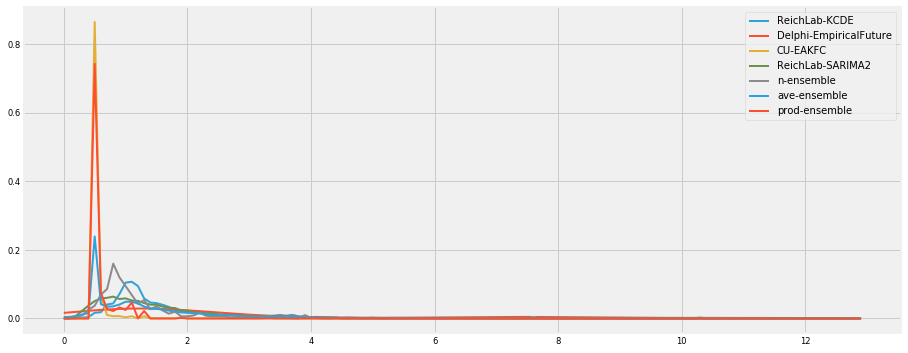

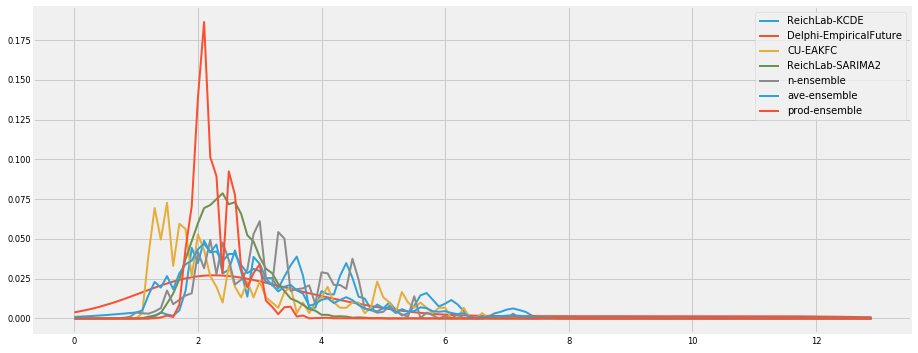

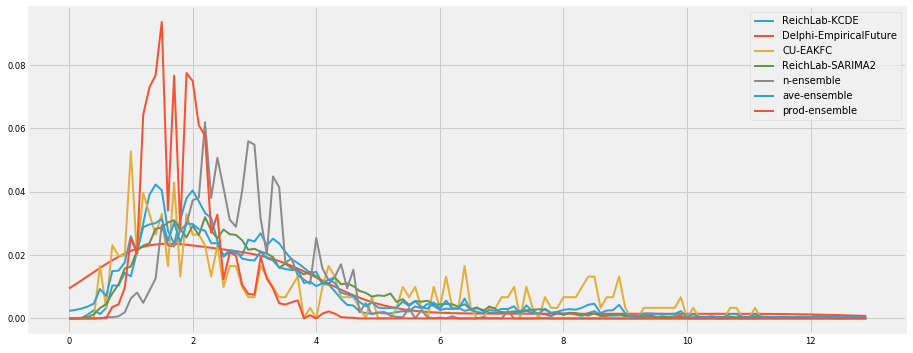

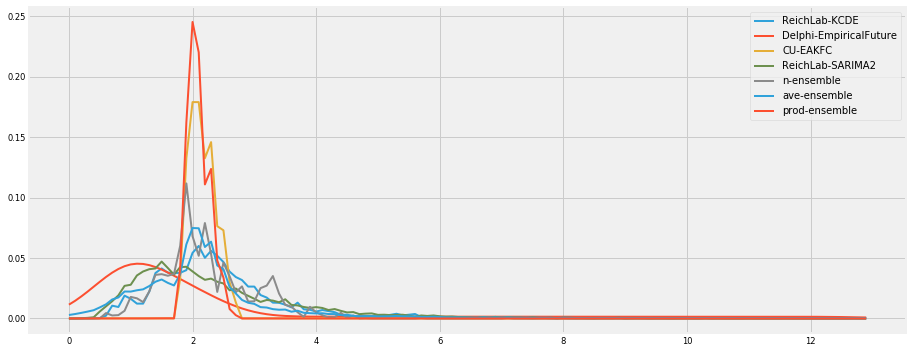

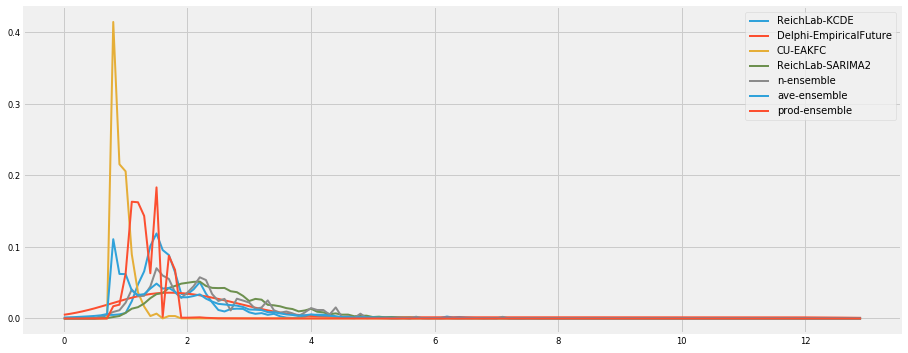

In [55]:
# Sample few of the examples
n_plots = 5
plot_indices = np.random.randint(0, y[~train_indices].shape[0], size=n_plots)

# y_plot_out = y[~train_indices][plot_indices]

component_dists = [cmp.data[~train_indices][plot_indices] for cmp in components]
n_dist = model.predict([X[~train_indices][plot_indices], weeks[~train_indices][plot_indices]])

dists = [
    *component_dists,
    n_dist,
    udists.mean_ensemble(component_dists),
    udists.prod_ensemble(component_dists)
]

bins = np.linspace(0, 12.9, 130)
mdls = [*[cmp.name for cmp in components], "n-ensemble", "ave-ensemble", "prod-ensemble"]

for pidx in range(n_plots):
    plt.figure(figsize=(14, 6))
    for idx, mdl in enumerate(mdls):
        plt.plot(bins, dists[idx][pidx], label=mdl)
    
    # Plot actual line
#     plt.axvline(x=y_plot_out[pidx])
    
    plt.legend()